# Read in the data

In [1]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Create dictionary to store all the csv files with their names as keys and dataframes as values

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}
for f in data_files:
    d = pandas.read_csv("data/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [4]:
# Read in survey data and contatenate row-wise

all_survey = pandas.read_csv("data/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pandas.read_csv("data/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pandas.concat([all_survey, d75_survey], axis=0)


# Create another column with capitalized letters

survey["DBN"] = survey["dbn"]


# Select necessary columns and update the data dictionary

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_10", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [5]:
# Update hs_directory's DBN column

data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    """ 
    This function is to pad the initial CSD column with zero to make
    it consistent    
    """
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation

    
# Apply the function to CSD column and make a new column called padded_csd

data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)


# Add DBN column in class_size dataset consists of padded_csd and school code

data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Calculate SAT Score

In [6]:
data['sat_results'].dtypes

DBN                                object
SCHOOL NAME                        object
Num of SAT Test Takers             object
SAT Critical Reading Avg. Score    object
SAT Math Avg. Score                object
SAT Writing Avg. Score             object
dtype: object

In [7]:
# Convert the SAT scores to numeric values

cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pandas.to_numeric(data["sat_results"][c], errors="coerce")

    
# Calculate the total SAT scores

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

# Extract schools' coordinates and convert to numeric values

In [8]:
def find_lat(loc):
    """
    This function is to extract school latitude 
    """
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    """
    This function is to extract school longitude 
    """
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

# Apply functions to hs_directory dataset and convert data type to numeric for further analysis

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pandas.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pandas.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [9]:
data['class_size'].DBN.value_counts().head()

15K429    57
09X517    56
09X505    56
15K448    52
21K690    52
Name: DBN, dtype: int64

In [10]:
"""
This section is to select a subset of the data to perform analysis.
"""

# Select students in 9th - 12th grade and participate in "GEN ED" program
# because we are only interested in high schools and "GEN ED" is the largest category

class_size = data["class_size"]
class_size = class_size[(class_size['GRADE '] == '09-12')&(class_size['PROGRAM TYPE'] == 'GEN ED')]

# Because school's DBN in sat_results dataset is unique, we can use groupby DBN to achieve this for merging
# Reset the index and assign the dataframe back to the dictionary for further analysis

class_size = class_size.groupby("DBN").agg(np.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size


# Because schoolyear column is causing duplicated DBNs, therefore select the most recent year (i.e. 20112012) 
# will solve this problem and keep other important data

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]


# In the graduation dataset, Cohort is causing the duplicated DBNs, thus select the most recent year's data
# and select the full cohort

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [11]:
# Convert AP scores to numeric values

cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pandas.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [12]:
# Some of the tables has many missing rows, therefore a left join is appropriate here to keep information
# in the sat_results table

combined = data["sat_results"]
combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")


# Because the goal of the project is to analyze SAT scores and demographic factors' correlations,
# so we want to keep as much information as possible in those tables

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

    
# Fill the null values with column means
combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [13]:
# The first two digits in the DBN column indicates the distrcit a school belongs to

def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

In [14]:
combined.head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon,school_dist
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.0,404.0,363.0,1122.0,0,129.028846,197.038462,...,Then to New York City residents,0,0,0,0,0,"220 Henry Street\nNew York, NY 10002\n(40.7137...",40.713764,-73.985260,01
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383.0,423.0,366.0,1172.0,UNIVERSITY NEIGHBORHOOD H.S.,39.000000,49.000000,...,0,0,0,0,0,0,"200 Monroe Street\nNew York, NY 10002\n(40.712...",40.712332,-73.984797,01
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377.0,402.0,370.0,1149.0,EAST SIDE COMMUNITY HS,19.000000,21.000000,...,0,0,0,0,0,0,"420 East 12 Street\nNew York, NY 10009\n(40.72...",40.729783,-73.983041,01
3,01M509,MARTA VALLE HIGH SCHOOL,44,390.0,433.0,384.0,1207.0,0,129.028846,197.038462,...,0,0,0,0,0,0,"145 Stanton Street\nNew York, NY 10002\n(40.72...",40.720569,-73.985673,01
4,01M539,"NEW EXPLORATIONS INTO SCIENCE, TECHNOLOGY AND ...",159,522.0,574.0,525.0,1621.0,"NEW EXPLORATIONS SCI,TECH,MATH",255.000000,377.000000,...,0,0,0,0,0,0,"111 Columbia Street\nNew York, NY 10002\n(40.7...",40.718725,-73.979426,01


# Find correlations

In [15]:
# Calculate the correlations between each variable and investigate sat_score correlations

correlations = combined.corr()
correlations_sat_scores = correlations['sat_score'][survey_fields]

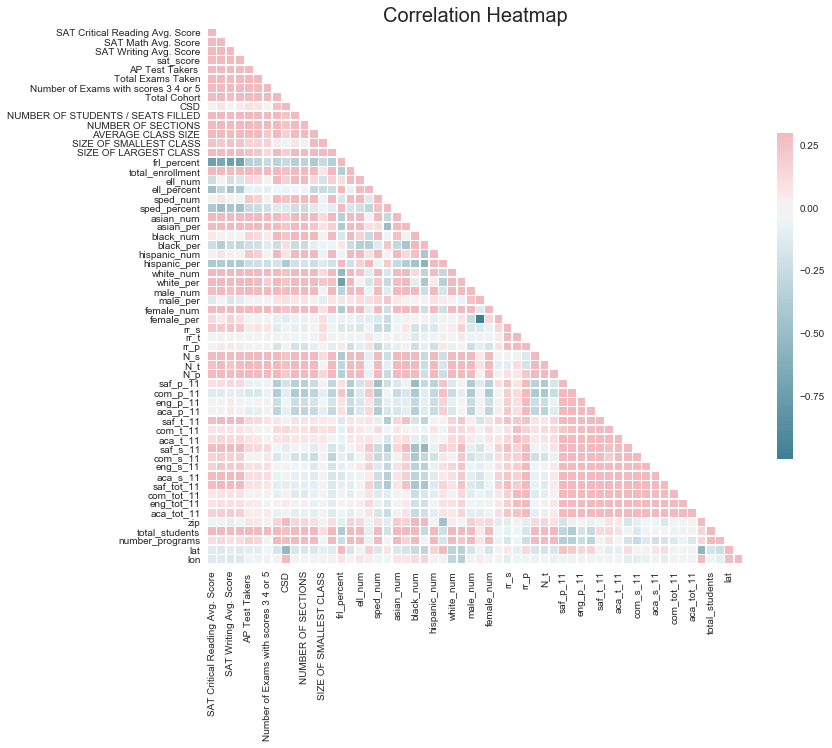

In [16]:
%matplotlib inline

# Drop columns and rows that have all the values as nulls
correlations = correlations.dropna(axis=[0,1], how='all')

sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.zeros_like(correlations, dtype=np.bool)
mask[np.triu_indices_from(mask, k=1)] = True # k = 0 (the default) is the main diagonal, 
                                                # k < 0 is below it and k > 0 is above.
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 12))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlations, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Correlation Heatmap', size = 20)
plt.show()

# Correlations Plots

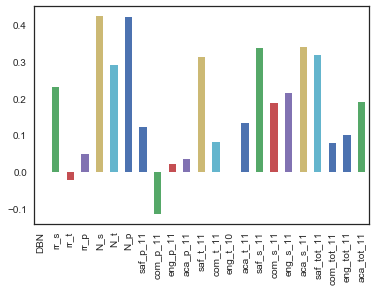

In [17]:
# Plot correlation between SAT score and survey fields
correlations_sat_scores[survey_fields].plot.bar()

The bar plots shows how each of the survey fields correlates with student's SAT score.

There are high correlations between N_s, N_t, N_p and sat_score.

Moreover, rr_s, the student response rate, correlates with sat_score. It might be the case that because students who are more likely to fill out surveys may be more likely to also be doing well academically.

How students and teachers percieved safety (saf_t_11 and saf_s_11) correlate with sat_score as a safer environment gives students better concentration and motivation to achieve higher grades.

# Create Scatter Plot

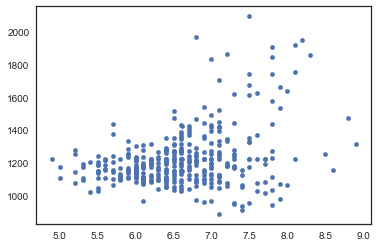

In [18]:
ax = plt.scatter(combined['saf_s_11'], combined['sat_score'], s=20)

# Examine by school districts

In [19]:
# Calculate means by school districts

districts = combined.groupby('school_dist').agg(np.mean)
districts.reset_index(inplace=True)

In [20]:
districts.head()

,school_dist,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5,Total Cohort,CSD,...,grade_span_max,expgrade_span_max,zip,total_students,number_programs,priority08,priority09,priority10,lat,lon
0,01,441.833333,473.333333,439.333333,1354.500000,116.681090,173.019231,135.800000,93.500000,1.0,...,12.0,12.0,10003.166667,659.500000,1.333333,0.0,0.0,0.0,40.719022,-73.982377
1,02,426.619092,444.186256,424.832836,1295.638184,128.908454,201.516827,157.495833,158.647849,2.0,...,12.0,12.0,10023.770833,621.395833,1.416667,0.0,0.0,0.0,40.739699,-73.991386
2,03,428.529851,437.997512,426.915672,1293.443035,156.183494,244.522436,193.087500,183.384409,3.0,...,12.0,12.0,10023.750000,717.916667,2.000000,0.0,0.0,0.0,40.781574,-73.977370
3,04,402.142857,416.285714,405.714286,1224.142857,129.016484,183.879121,151.035714,113.857143,4.0,...,12.0,12.0,10029.857143,580.857143,1.142857,0.0,0.0,0.0,40.793449,-73.943215
4,05,427.159915,438.236674,419.666098,1285.062687,85.722527,115.725275,142.464286,143.677419,5.0,...,12.0,12.0,10030.142857,609.857143,1.142857,0.0,0.0,0.0,40.817077,-73.949251


(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

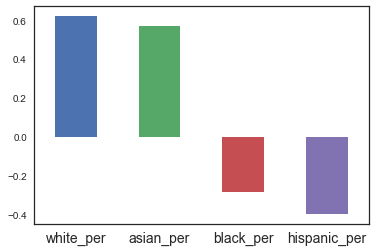

In [21]:
# Examine correlations between ethnicity and sat_scores

correlations['sat_score'][['white_per', 'asian_per', 'black_per', 'hispanic_per']].plot.bar()
plt.xticks(rotation=0, fontsize=14)

The graph above indicates that both white and asian students have higher percentage in correlation with the SAT score, whereas black and hispanic students have higher percentage that correlate negtively with SAT score.

# Dive Deeper

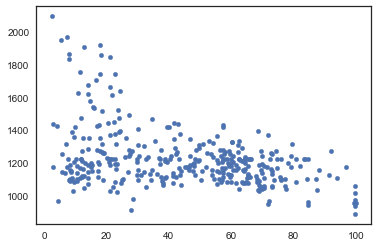

In [22]:
# Create scatter plot to examine hispanic_per and sat_score

plt.scatter(combined['hispanic_per'], combined['sat_score'], s=20)

In [23]:
combined[['hispanic_per', 'sat_score']].corr()

,hispanic_per,sat_score
hispanic_per,1.000000,-0.396985
sat_score,-0.396985,1.000000


In [24]:
combined[combined['hispanic_per']>95]['SCHOOL NAME']

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

In [25]:
combined[(combined['hispanic_per']<10)&(combined['sat_score']>1800)]['SCHOOL NAME']

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

Because hispanic students have higher percentage in negative correlation with sat_score, it is worth investigation.
As the above data indicates, schools with more than 95% hispanic population are likely to be international schools, whereas schools with low hispanic population and higher SAT_schools are mostly science and technology oriented schools.

(array([0, 1]), <a list of 2 Text xticklabel objects>)

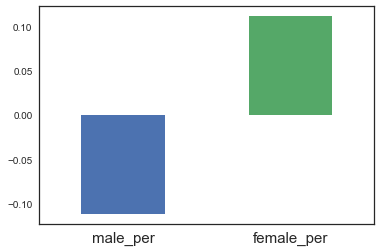

In [26]:
correlations['sat_score'][['male_per', 'female_per']].plot.bar()
plt.xticks(rotation=0, fontsize=15)

This plot shows that female students have a higher percentage of positive correlation with sat_score whereas male students have a higher percentage of negative correlation with sat_score, even though the correlations are not strong.

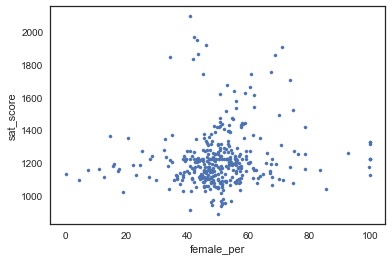

In [27]:
combined.plot.scatter('female_per', 'sat_score', s=10)

There are a number of schools with 50% female ratio achieve high SAT scores (>1800)

In [28]:
combined[(combined['female_per']>60)&(combined['sat_score']>1700)]['SCHOOL NAME']

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

# AP test score and SAT score

In [29]:
combined['ap_per'] = combined['AP Test Takers ']/combined['total_enrollment']

In [30]:
combined[['AP Test Takers ', 'total_enrollment', 'ap_per']].head()

,AP Test Takers,total_enrollment,ap_per
0,129.028846,422,0.305756
1,39.000000,394,0.098985
2,19.000000,598,0.031773
3,129.028846,367,0.351577
4,255.000000,1613,0.158091


In [31]:
combined[['ap_per', 'sat_score']].corr()

,ap_per,sat_score
ap_per,1.000000,0.057171
sat_score,0.057171,1.000000


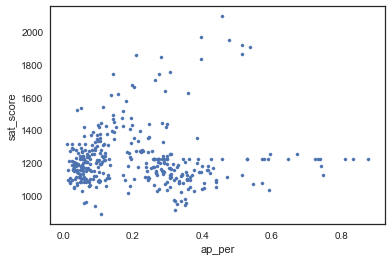

In [32]:
combined.plot.scatter('ap_per', 'sat_score', s=10)

The correlation between the percentage of students take AP tests and their SAT scores are not strongly correlated, though they are slightly positively correlated (0.057).